## Implementing a Perceptron in Pytorch
### With a learning example

In [1]:
# Import libraries
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import random
import os
import glob
import pickle
import time
import string
from PIL import Image
import numpy as np
import json

import torch as torch
import torch.nn as nn    
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models

In [2]:
print("Using PyTorch version: " + str(torch.__version__))

Using PyTorch version: 1.0.0


In [3]:
use_gpu = False
torch.manual_seed(7)

**Setup the dataset**

In [4]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/train/', download=True, train=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data/valid/', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

**Build a classifier**

In [5]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.LogSoftmax()
        
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

**Define the Perceptron module**

In [6]:
class Perceptron(nn.Module):
    def __init__(self, inputs, outputs, minimum = 0.0):
        super(Perceptron, self).__init__()
        self.inputs = inputs
        self.outputs = outputs
        
        # student network
        self.Sb = Parameter(torch.ones(self.outputs, requires_grad=True))
        self.SW = Parameter(torch.randn(self.outputs, self.inputs, requires_grad=True))
        #print("SW shape: {}\nSb shape: {}".format(self.SW.size(), self.Sb.size()))
        
        # teacher network
        self.S_o, self.S_i = self.SW.size()
        self.Tb = Parameter(torch.ones(self.S_o * self.S_i, requires_grad=True))
        self.TW = Parameter(torch.randn(self.S_o * self.S_i, self.inputs, requires_grad=True))
        #print("TW shape: {}\nTb shape: {}".format(self.TW.size(), self.Tb.size()))
        
        self.min_val = torch.tensor(minimum).float()
        
        
    def forward(self, x):
        # teacher signal
        #print("x shape: {}".format(x.size()))
        self.Tz = F.linear(x, self.TW, self.Tb)
        #print("Tz shape: {}\nTW shape: {}\nTb shape: {}".format(self.Tz.size(), self.TW.size(), self.Tb.size()))
        self.Th = torch.matmul(self.Tz.t(), torch.ones(x.size()[0]))
        # perceptron gate
        self.o = torch.gt(self.Th, self.min_val).float()
        #print("o shape: {}".format(self.o.size()))
        
        self.o = self.o.view(self.S_o, self.S_i)
        #print("o shape: {}".format(self.o.size()))
        self.W = torch.mul(self.o, self.SW)
        
        # student signal
        x = F.linear(x, self.W, self.Sb)
        
        return x

In [7]:
class Tron(nn.Module):
    def __init__(self):
        super(Tron, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.tron1 = Perceptron(16*5*5, 120)
        self.tron2 = Perceptron(120, 84)
        
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        
        x = self.tron1(x)
        x = self.tron2(x)
        
        x = self.fc3(x)
        x = self.softmax(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Training the network

**Loss plotting functions**

In [8]:
def plot_training(train_losses, valid_losses, title):
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training ' + title)
    plt.plot(valid_losses, label='Validation ' + title)
    plt.xlabel('epochs')
    plt.legend(frameon=False)
    plt.title(title)
    plt.show()

**Train the network**

In [9]:
def train(model, epoch, criterion, optimizer):
    
    model.train()
    train_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        
        data, target = Variable(data), Variable(target)
        
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        
        train_loss += loss.item()
        
        predicted = torch.max(output, 1)[1]
        correct += (predicted == target).float().sum()
        
        optimizer.step()
        
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
        
    return train_loss, correct / len(train_loader.dataset)

In [10]:
def test(model, criterion, optimizer):
    model.eval()
    
    test_loss = 0
    correct = 0
    
    for data, target in test_loader:
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        
        data, target = Variable(data), Variable(target)
        
        output = model(data)
        loss = criterion(output, target)
        
        test_loss += loss.item()
        predicted = torch.max(output, 1)[1]
        correct += (predicted == target).float().sum()
    
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, correct / len(test_loader.dataset)

In [11]:
# Train Model
def train_model(model, epochs):
    
    criteria = nn.NLLLoss()
    optimise = optim.SGD(model.parameters(), lr=0.003)
    #scheduler = optim.lr_scheduler.StepLR(optimise, step_size=20, gamma=0.5)
    
    train_losses, train_accs = [], []
    valid_losses, valid_accs = [], []

    for e in range(epochs):
        print("Epoch: {} ...".format(e))
        #scheduler.step()
        
        t_loss, t_acc = train(model, e, criteria, optimise)
        v_loss, v_acc = test(model, criteria, optimise)

        train_losses.append(t_loss)
        valid_losses.append(v_loss)
        train_accs.append(t_acc)
        valid_accs.append(v_acc)
    
    plot_training(train_losses, valid_losses, 'Loss')
    plot_training(train_accs, valid_accs, 'Accuracy')

In [12]:
# Training Parameters
epochs = 5

**Train LeNet5**

In [13]:
# Standard LeNet5
model1 = LeNet5()

Epoch: 0 ...


C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Train set: Average loss: 2154.0102, Accuracy: 6664.0/60000 (11.11%)
Test set: Average loss: 358.8486, Accuracy: 2073.0/10000 (20.73%)

Epoch: 1 ...

Train set: Average loss: 2103.9591, Accuracy: 26521.0/60000 (44.20%)
Test set: Average loss: 334.1136, Accuracy: 5597.0/10000 (55.97%)

Epoch: 2 ...

Train set: Average loss: 1272.3104, Accuracy: 39112.0/60000 (65.19%)
Test set: Average loss: 106.3572, Accuracy: 7909.0/10000 (79.09%)

Epoch: 3 ...

Train set: Average loss: 438.5061, Accuracy: 51632.0/60000 (86.05%)
Test set: Average loss: 54.3292, Accuracy: 8918.0/10000 (89.18%)

Epoch: 4 ...

Train set: Average loss: 282.8247, Accuracy: 54559.0/60000 (90.93%)
Test set: Average loss: 39.2924, Accuracy: 9190.0/10000 (91.90%)



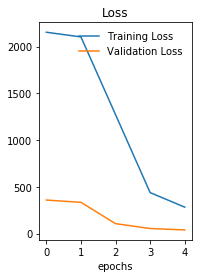

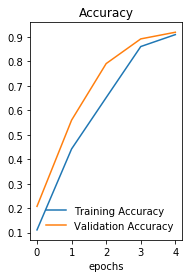

In [14]:
train_model(model1, epochs)

**Train MLP Activation Network**

In [15]:
# Model with MLP Activation
model2 = Tron()

Epoch: 0 ...


C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Train set: Average loss: 673.1965, Accuracy: 49898.0/60000 (83.16%)
Test set: Average loss: 64.5144, Accuracy: 8897.0/10000 (88.97%)

Epoch: 1 ...

Train set: Average loss: 205.8413, Accuracy: 56215.0/60000 (93.69%)
Test set: Average loss: 31.9245, Accuracy: 9415.0/10000 (94.15%)

Epoch: 2 ...

Train set: Average loss: 153.9128, Accuracy: 57098.0/60000 (95.16%)
Test set: Average loss: 24.8715, Accuracy: 9533.0/10000 (95.33%)

Epoch: 3 ...

Train set: Average loss: 132.3122, Accuracy: 57451.0/60000 (95.75%)
Test set: Average loss: 22.5384, Accuracy: 9560.0/10000 (95.60%)

Epoch: 4 ...

Train set: Average loss: 118.8896, Accuracy: 57743.0/60000 (96.24%)
Test set: Average loss: 19.3687, Accuracy: 9627.0/10000 (96.27%)



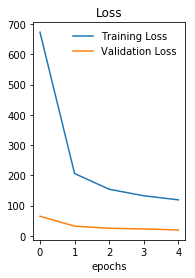

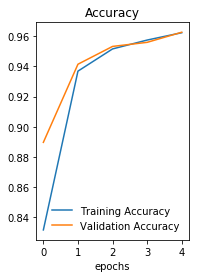

In [16]:
# Training Model 2
train_model(model2, epochs)